In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot  as plt
import torch.nn.functional as F
from torchvision.datasets import DatasetFolder
import cv2

device  = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
!git clone https://github.com/skokalj/RowanDLclassNEA.git

fatal: destination path 'RowanDLclassNEA' already exists and is not an empty directory.


In [3]:
from torchvision import transforms
import PIL.Image


def load_image(img_path:str):    
        np_img = cv2.imread(img_path)
        return PIL.Image.fromarray(np_img)

dset = DatasetFolder(root=r'RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',))

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root=r'RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

In [4]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)


In [5]:
data, label = next(iter(trainloader))

data.shape

torch.Size([16, 3, 224, 224])

In [6]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1)
    
    def forward(self, x):
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





In [7]:
import torch
import torch.optim as optim
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
autoencoder = Autoencoder().to(device=device)
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01, momentum=0.9)

N_EPOCHS = 50
tr_loss_hist = []
val_loss_hist = []

for epoch in range(N_EPOCHS):

    train_loss = 0.0
    autoencoder.train()
    
    for inputs, _ in trainloader:
        inputs = inputs.to(device)
        
        optimizer.zero_grad()

        outputs = autoencoder(inputs)
        resize_transform = transforms.Resize((224, 224))
        outputs = resize_transform(outputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    val_loss = 0.0
    autoencoder.eval()
    
    for inputs, _ in valloader:
        inputs = inputs.to(device)

        outputs = autoencoder(inputs)
        resize_transform = transforms.Resize((224, 224))
        outputs = resize_transform(outputs)
        loss = criterion(outputs, inputs)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
        epoch, train_loss / len(trainloader), val_loss / len(valloader)))
    tr_loss_hist.append(train_loss / len(trainloader))
    val_loss_hist.append(val_loss / len(valloader))


c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0 Train Loss: 0.9448308054606119 Val Loss: 0.9056618637160251
Epoch: 1 Train Loss: 0.9136919665336609 Val Loss: 0.8787455190169183
Epoch: 2 Train Loss: 0.8980738095442454 Val Loss: 0.863718024209926
Epoch: 3 Train Loss: 0.8902680500348409 Val Loss: 0.859459292731787
Epoch: 4 Train Loss: 0.8857079108556112 Val Loss: 0.8540434586374384
Epoch: 5 Train Loss: 0.8829828910032909 Val Loss: 0.8567193330902803
Epoch: 6 Train Loss: 0.8812591584523519 Val Loss: 0.8592999789275622
Epoch: 7 Train Loss: 0.8800425227483114 Val Loss: 0.846468365506122
Epoch: 8 Train Loss: 0.8791759626070659 Val Loss: 0.8502309604694969
Epoch: 9 Train Loss: 0.8786619873841603 Val Loss: 0.8559394086662092
Epoch: 10 Train Loss: 0.878176064491272 Val Loss: 0.8529743097330394
Epoch: 11 Train Loss: 0.8778266421953838 Val Loss: 0.8530622846201846
Epoch: 12 Train Loss: 0.877572299639384 Val Loss: 0.8474722386975038
Epoch: 13 Train Loss: 0.8773988183339437 Val Loss: 0.8448863923549652
Epoch: 14 Train Loss: 0.87722347180

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

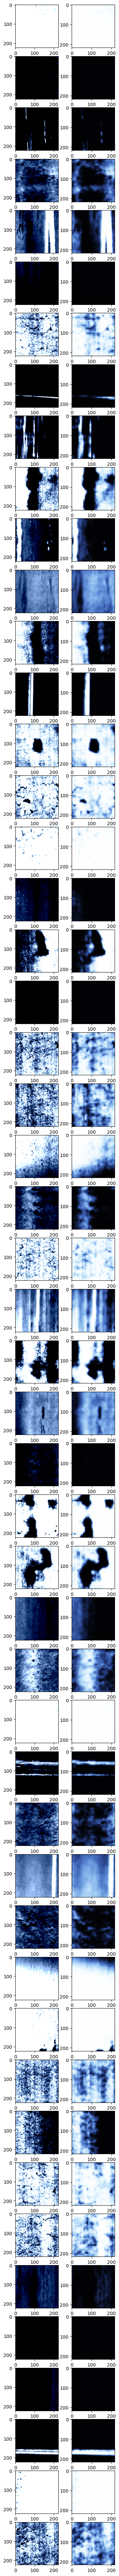

In [12]:
import matplotlib.pyplot as plt

autoencoder.eval()
originals = []
reconstructed = []

tset = DatasetFolder(root=r'RowanDLclassNEA/NEUdata_split/Test', loader=load_image, extensions=('.bmp',), transform=transform)

test_loader = torch.utils.data.DataLoader(
    tset,
    batch_size=50,
    shuffle=True)

for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = autoencoder(inputs)

    inputs_np = inputs.cpu().detach().numpy()
    outputs_np = outputs.cpu().detach().numpy()

    originals.extend(inputs_np)
    reconstructed.extend(outputs_np)

originals = np.array(originals)
reconstructed = np.array(reconstructed)

#print(reconstructed[0])

num_images = len(originals[:50])


fig = plt.figure(figsize=(4,100))

print(num_images)

for i in range(50):
    fig.add_subplot(50,2,2*i+1)
    #print(originals[0].shape)
    plt.imshow(originals[i].transpose((1, 2, 0)))  
    fig.add_subplot(50,2,2*i+2)
    #print(reconstructed[0].shape)
    plt.imshow(reconstructed[i].transpose((1, 2, 0)))  


plt.show()


In [17]:
torch.save(autoencoder.state_dict(),"./AE_model.pt")

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
autoencoder = Autoencoder().to(device=device)
autoencoder_s = autoencoder.load_state_dict(torch.load("./AE_model.pt",map_location=torch.device('cpu')))

In [19]:
import matplotlib.pyplot as plt

autoencoder_s.eval()
originals = []
reconstructed = []

tset = DatasetFolder(root=r'RowanDLclassNEA/NEUdata_split/Test', loader=load_image, extensions=('.bmp',), transform=transform)

test_loader = torch.utils.data.DataLoader(
    tset,
    batch_size=50,
    shuffle=True)

for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = autoencoder_s(inputs)

    inputs_np = inputs.cpu().detach().numpy()
    outputs_np = outputs.cpu().detach().numpy()

    originals.extend(inputs_np)
    reconstructed.extend(outputs_np)

originals = np.array(originals)
reconstructed = np.array(reconstructed)

#print(reconstructed[0])

num_images = len(originals[:50])


fig = plt.figure(figsize=(4,100))

print(num_images)

for i in range(1):
    fig.add_subplot(50,2,2*i+1)
    print(originals[0].shape)
    plt.imshow(originals[i].transpose((1, 2, 0)))  
    fig.add_subplot(50,2,2*i+2)
    print(reconstructed[0].shape)
    plt.imshow(reconstructed[i].transpose((1, 2, 0)))  


plt.show()


AttributeError: '_IncompatibleKeys' object has no attribute 'eval'